In [1]:
from datasets import Dataset

train_dataset = Dataset.from_file("/kaggle/input/conv-dataset/conv_data/therapy_train/data-00000-of-00001.arrow")
val_dataset = Dataset.from_file("/kaggle/input/conv-dataset/conv_data/therapy_val/data-00000-of-00001.arrow")
test_dataset = Dataset.from_file("/kaggle/input/conv-dataset/conv_data/therapy_test/data-00000-of-00001.arrow")


In [2]:
from datasets import Dataset, DatasetDict
import re

def segment_conversation(batch, window_size=6, min_len=4):
    input_texts = batch['input_text']
    target_texts = batch['target_text']
    
    new_inputs = []
    new_targets = []

    for input_text, target_text in zip(input_texts, target_texts):
        utterances = [u.strip() for u in input_text.split('[SEP]') if u.strip()]
        n = len(utterances)

        if n <= window_size:
            new_inputs.append(input_text)
            new_targets.append(target_text)
            continue

        i = min_len
        while i < n:
            j = i
            while j < n and not utterances[j].startswith("T:"):
                j += 1
            
            if j < n:
                window_start = max(0, j - window_size)
                window = utterances[window_start:j]
                new_inputs.append(' [SEP] '.join(window))
                new_targets.append(re.sub(r"^T:\s*", "", utterances[j]).strip())
                i = j + 1
            else:
                window = utterances[max(0, n - window_size):n]
                new_inputs.append(' [SEP] '.join(window))
                new_targets.append(target_text)
                break

    return {"input_text": new_inputs, "target_text": new_targets}

new_train_data = train_dataset.map(
    segment_conversation,
    batched=True,
    remove_columns=train_dataset.column_names,
    load_from_cache_file=False,
    keep_in_memory=True
)


Map:   0%|          | 0/4008 [00:00<?, ? examples/s]

In [3]:
import datasets

def deduplicate(dataset):
    seen = set()
    new_data = {"input_text": [], "target_text": []}
    
    for inp, tgt in zip(dataset["input_text"], dataset["target_text"]):
        if inp not in seen:
            seen.add(inp)
            new_data["input_text"].append(inp)
            new_data["target_text"].append(tgt)
    
    return datasets.Dataset.from_dict(new_data)

deduped_train_data = deduplicate(new_train_data)


In [4]:
# print(train_dataset)
print(train_dataset[0])


{'input_text': 'T: Hi you how to do it today? [SEP] P: Great. How are you?', 'target_text': "I'm doing well. Thanks for asking."}


In [5]:
print(new_train_data[0])


{'input_text': 'T: Hi you how to do it today? [SEP] P: Great. How are you?', 'target_text': "I'm doing well. Thanks for asking."}


In [6]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch

# Load sentiment model
sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModel.from_pretrained(sentiment_model_name)

for param in sentiment_model.parameters():
    param.requires_grad = False


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

2025-04-15 14:43:31.827852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744728212.042860      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744728212.108002      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [7]:
class SentimentFusion(nn.Module):
    def __init__(self, hidden_size=768, n_heads=8):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=n_heads, batch_first=True)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.proj = nn.Linear(hidden_size * 2, hidden_size)  # Project back to the original hidden size

    def forward(self, token_embeddings, sentiment_vector):
        sentiment_expanded = sentiment_vector.unsqueeze(1).expand(-1, token_embeddings.size(1), -1)  # (batch, seq_len, hidden)

        # Concatenate sentiment and token embeddings along the last dimension
        fused_embeddings = torch.cat((token_embeddings, sentiment_expanded), dim=-1)

        # Project back to the original hidden size before passing to attention
        fused_embeddings = self.proj(fused_embeddings)

        # Apply attention: query=token_embeddings, key&value=fused_embeddings
        attn_output, _ = self.attention(query=fused_embeddings,
                                        key=fused_embeddings,
                                        value=fused_embeddings)

        # Optionally add residual connection
        fused = token_embeddings + attn_output
        return self.linear(fused)


In [8]:
from transformers import BartTokenizer, BartForConditionalGeneration, AutoTokenizer, AutoModel
import torch
import torch.nn as nn

class SentimentInfusedBart(nn.Module):
    def __init__(self, 
                 bart_model_name="facebook/bart-base",
                 sentiment_model_name="cardiffnlp/twitter-roberta-base-sentiment",
                 hidden_size=768,
                 n_heads=8,
                 device=None):
        super().__init__()

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load BART components
        self.tokenizer = BartTokenizer.from_pretrained(bart_model_name)
        self.bart = BartForConditionalGeneration.from_pretrained(bart_model_name).to(self.device)
        
        # Load Sentiment Model
        self.sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
        self.sentiment_model = AutoModel.from_pretrained(sentiment_model_name).to(self.device)
        
        for param in self.sentiment_model.parameters():
            param.requires_grad = False

        self.fusion = SentimentFusion(hidden_size, n_heads).to(self.device)

    def get_sentiment_embedding(self, input_texts):
        inputs = self.sentiment_tokenizer(
            input_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )
    
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
    
        outputs = self.sentiment_model(**inputs)
        return outputs.last_hidden_state[:, 0, :]  # CLS token embedding

    def forward(self, input_texts, target_texts=None):
        device = next(self.parameters()).device

        encoded = self.tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        token_embeddings = self.bart.model.encoder.embed_tokens(input_ids)  # (batch, seq_len, hidden)

        with torch.no_grad():
            sentiment_vectors = self.get_sentiment_embedding(input_texts).to(device)

        fused_embeddings = self.fusion(token_embeddings, sentiment_vectors)

        encoder_outputs = self.bart.model.encoder(inputs_embeds=fused_embeddings, attention_mask=attention_mask)

        if target_texts is not None:
            with self.tokenizer.as_target_tokenizer():
                labels = self.tokenizer(target_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).input_ids.to(device)
            
            output = self.bart(
                encoder_outputs=encoder_outputs,
                attention_mask=attention_mask,
                labels=labels
            )
            return output
        else:
            generated_ids = self.bart.generate(
                encoder_outputs=encoder_outputs,
                attention_mask=attention_mask,
                max_length=50,
                num_beams=4,
                early_stopping=True
            )
            return self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    def generate_response(self, input_texts, max_length=50):
        self.eval()
        with torch.no_grad():
            encoded = self.tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
            input_ids = encoded["input_ids"].to(self.device)
            attention_mask = encoded["attention_mask"].to(self.device)
    
            token_embeddings = self.bart.model.encoder.embed_tokens(input_ids)
    
            sentiment_vectors = self.get_sentiment_embedding(input_texts).to(self.device)
    
            fused_embeddings = self.fusion(token_embeddings, sentiment_vectors)
    
            encoder_outputs = self.bart.model.encoder(inputs_embeds=fused_embeddings, attention_mask=attention_mask)
    
            generated_ids = self.bart.generate(
                encoder_outputs=encoder_outputs,
                attention_mask=attention_mask,
                max_length=max_length,
                do_sample=True,
                top_p=0.92,
                temperature=0.9,
                top_k=50,
                num_return_sequences=1
            )

    
            return self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)


In [9]:
from torch.utils.data import Dataset

class TherapyDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_input_len=512, max_target_len=128):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        input_text = item["input_text"]
        target_text = item["target_text"]

        input_enc = self.tokenizer(input_text,
                                   padding='max_length',
                                   truncation=True,
                                   max_length=self.max_input_len,
                                   return_tensors="pt")

        target_enc = self.tokenizer(target_text,
                                    padding='max_length',
                                    truncation=True,
                                    max_length=self.max_target_len,
                                    return_tensors="pt")

        return {
            "input_text": input_text,
            "target_text": target_text,
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": target_enc["input_ids"].squeeze()
        }


In [10]:
from torch.utils.data import DataLoader

model = SentimentInfusedBart()

# Instantiate dataset objects
model_tokenizer = model.tokenizer

train_ds = TherapyDataset(deduped_train_data, model_tokenizer)
val_ds = TherapyDataset(val_dataset, model_tokenizer)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model = SentimentInfusedBart()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from torch.nn import functional as F
from tqdm import tqdm

def train(model, train_loader, val_loader, epochs=3, lr=1e-5, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_texts = batch["input_text"]
            target_texts = batch["target_text"]

            outputs = model(input_texts, target_texts=target_texts)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")


In [13]:
train(model, train_loader, val_loader, epochs=5, lr=1e-5, device=device)

Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Epoch 1: 100%|██████████| 500/500 [03:04<00:00,  2.70it/s]


Epoch 1 training loss: 2.9948


Epoch 2: 100%|██████████| 500/500 [03:03<00:00,  2.72it/s]


Epoch 2 training loss: 1.4238


Epoch 3: 100%|██████████| 500/500 [03:03<00:00,  2.72it/s]


Epoch 3 training loss: 1.3455


Epoch 4: 100%|██████████| 500/500 [03:04<00:00,  2.70it/s]


Epoch 4 training loss: 1.3110


Epoch 5: 100%|██████████| 500/500 [03:04<00:00,  2.71it/s]

Epoch 5 training loss: 1.2870


In [14]:
from torch.utils.data import DataLoader
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# from bert_score import score

# Create DataLoader for test dataset
test_dataset = TherapyDataset(test_dataset, model_tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [15]:
model.eval()
predictions = []
references = []

for batch in test_loader:
    input_texts = batch["input_text"]
    target_texts = batch["target_text"]

    for input_text, target in zip(input_texts, target_texts):
        with torch.no_grad():
            generated_text = model.generate_response(input_text, max_length=50)
        predictions.append(generated_text[0])
        references.append(target)

# Print a few examples
for i in range(5):
    print(f"Ground Truth: {references[i]}")
    print(f"Prediction: {predictions[i]}")

Ground Truth: Are you evaluated at work by anybody to see if you're in a job you should be?
Prediction: What year is this?
Ground Truth: Have you been Found in that system to be somebody who's satisfying the requirements of in terms of competency satisfy the requirements of employee.
Prediction: I'm going to ask you a few questions. I want to get you in to see a counselor.
Ground Truth: that's a good sign. Yeah, you haven't been fired. Have you ever had any type of write up or somebody discussing something with you?
Prediction: Okay. So you want to be a good mom?
Ground Truth: Alright, so there's no there's no evidence supporting that. In a kind of a direct fashion, like a supervisor coming to, but there's no other evidence supporting it based on your, what you're feeling, how you're perceiving things. Yeah, you're getting this feeling that, by the way, they're interacting with you.
Prediction: Okay. Okay. So it sounds like you're having some difficulties with your relationship with yo

In [16]:
# BLEU score calculation
smooth = SmoothingFunction().method4
bleu_scores = [
    sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth)
    for ref, pred in zip(references, predictions)
]
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu:.4f}")

Average BLEU Score: 0.0104


In [17]:
!pip install bert_score
from bert_score import score

# BERTScore calculation
P, R, F1 = score(predictions, references, lang="en", verbose=True)
print(f"BERTScore F1: {F1.mean().item():.4f}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/28 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 7.25 seconds, 133.57 sentences/sec
BERTScore F1: 0.8480


In [ ]:
!pip install rouge-score


In [21]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

print(f"ROUGE-1 F1: {sum(rouge1_scores) / len(rouge1_scores):.4f}")
print(f"ROUGE-2 F1: {sum(rouge2_scores) / len(rouge2_scores):.4f}")
print(f"ROUGE-L F1: {sum(rougeL_scores) / len(rougeL_scores):.4f}")


ROUGE-1 F1: 0.1428
ROUGE-2 F1: 0.0187
ROUGE-L F1: 0.1170


In [ ]:
torch.save(model.state_dict(), "wasif_sliding_window_fused_model.pt")


In [22]:
import matplotlib.pyplot as plt

def plot_training_loss(training_loss):
    epochs = list(range(1, len(training_loss) + 1))
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, training_loss, marker='o', linestyle='-', color='blue', label='Training Loss')
    plt.title('Training Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


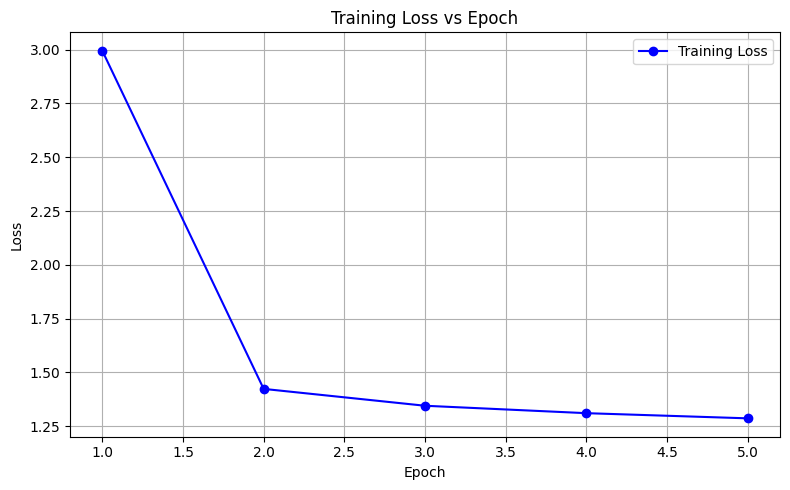

In [26]:
losses = [2.9948, 1.4238, 1.3455, 1.3110, 1.2870]
plot_training_loss(losses)

In [ ]:
model = SentimentInfusedBart()
model.load_state_dict(torch.load("/kaggle/input/trained-models/my model/wasif_sliding_window_fused_model.pt", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()
